# Importing Libraries and Functions

In [ ]:
from sentenceSegmentation import SentenceSegmentation
from tokenization import Tokenization
from inflectionReduction import InflectionReduction
from stopwordRemoval import StopwordRemoval
from informationRetrieval import InformationRetrieval
from evaluationMetrics import Evaluation_metrics # this is to plot and table of results at every k
from evaluation import Evaluation
from hypoTesting import hypothesis_test
from observations import plot, plot_comp
# For additional corpus
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus.reader import wordnet
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# For hypothesis testing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string
import json
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Import Data
The data provided here has undergone preprocessing in a previous assignments. We intend to build upon this preprocessing and further enhance the Vector Space Model  (Modified VSM) by incorporating additional preprocessing techniques.

In [ ]:
# Read queries
queries_json = json.load(open( ".\cranfield\cran_queries.json", 'r'))[:]
query_ids, queries = [item["query number"] for item in queries_json], [item["query"] for item in queries_json]

# Read documents(corpus)
docs_json = json.load(open(".\cranfield\cran_docs.json", 'r'))[:]
doc_ids, docs = [item["id"] for item in docs_json], [item["body"] for item in docs_json]

qrels = json.load(open( "./cranfield/cran_qrels.json", 'r'))[:]

# 1. Vanilla VSM (VSM-1)

## Processing

In [ ]:
# Loading preprocessed queries
Preprocessed_queries = json.load(open('.\output_VSM-1\stopword_removed_queries.txt', 'r'))
# Loading Preprocessed docs
Preprocessed_docs = json.load(open('.\output_VSM-1\stopword_removed_docs.txt', 'r'))

In [ ]:
type(Preprocessed_docs)

list

In [ ]:
# Flatten the list of lists of lists into a single list
flattened_docs = [word for sublist1 in Preprocessed_docs for sublist2 in sublist1 for word in sublist2]
# Count the number of distinct tokens
num_distinct_tokens = len(set(flattened_docs))
print("Number of distinct tokens:", num_distinct_tokens)

Number of distinct tokens: 9648


In [ ]:
# Instantiate the InformationRetrieval class
informationRetriever  = InformationRetrieval()
# Build the index
informationRetriever.buildIndex(Preprocessed_docs, doc_ids)
# Get the ordered document IDs for the queries
doc_IDs_ordered_vsm1 = informationRetriever.rank(Preprocessed_queries)

## Evaluation

Precision, Recall, and F-score @ 1: 0.6133333333333333, 0.10199455854040027, 0.1685039906512885
MAP, nDCG @ 1: 0.10199455854040027, 0.42370370370370397
Precision, Recall, and F-score @ 2: 0.5177777777777778, 0.168445282556574, 0.2392765695799333
MAP, nDCG @ 2: 0.16167447928577072, 0.4140292503335941
Precision, Recall, and F-score @ 3: 0.4637037037037038, 0.21451843203170567, 0.27340170269780023
MAP, nDCG @ 3: 0.19651426989665258, 0.4170006377609946
Precision, Recall, and F-score @ 4: 0.42, 0.25288988184961636, 0.29247319660714716
MAP, nDCG @ 4: 0.22049446858427732, 0.41684759986476116
Precision, Recall, and F-score @ 5: 0.38044444444444453, 0.2830009091790346, 0.29982886956151206
MAP, nDCG @ 5: 0.2371212196960859, 0.4204288984341635
Precision, Recall, and F-score @ 6: 0.3496296296296296, 0.3110397733649576, 0.3039910892855758
MAP, nDCG @ 6: 0.2510425729131907, 0.42455894251669296
Precision, Recall, and F-score @ 7: 0.32507936507936547, 0.33342083732641375, 0.3040090427814017
MAP, nDCG 

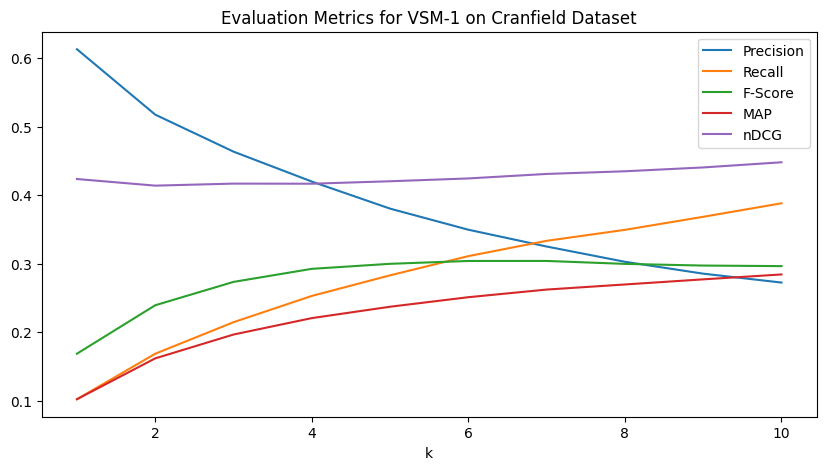

In [ ]:
# from evaluationAllMetrics import Evaluation_metrics
Evaluation_metrics(doc_IDs_ordered_vsm1, query_ids, qrels,save_results=1, title_name="Evaluation Metrics for VSM-1 on Cranfield Dataset")

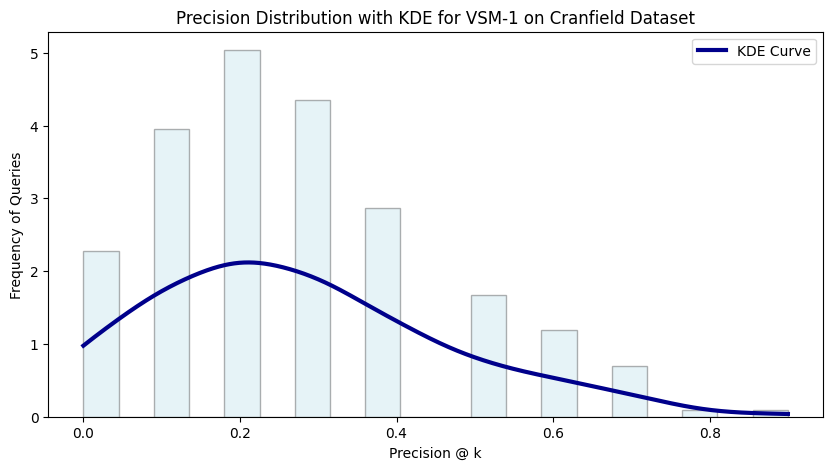

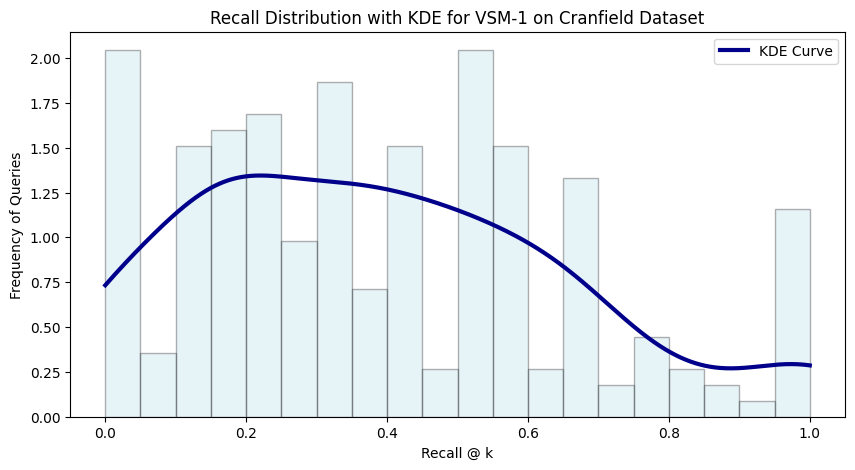

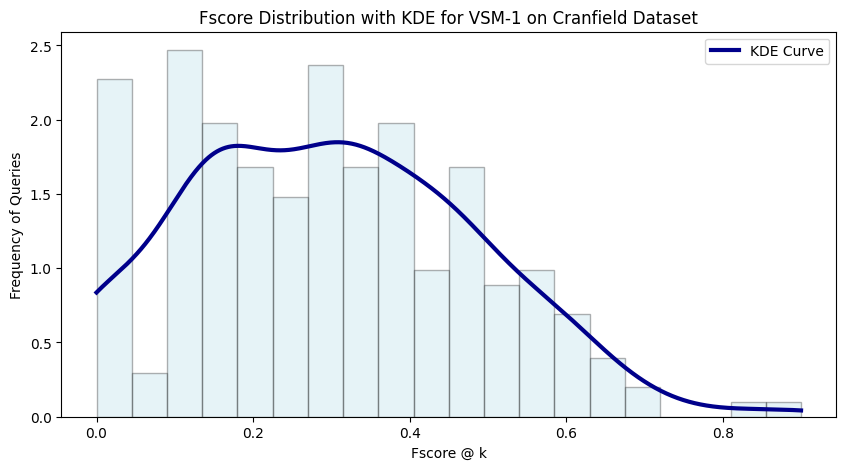

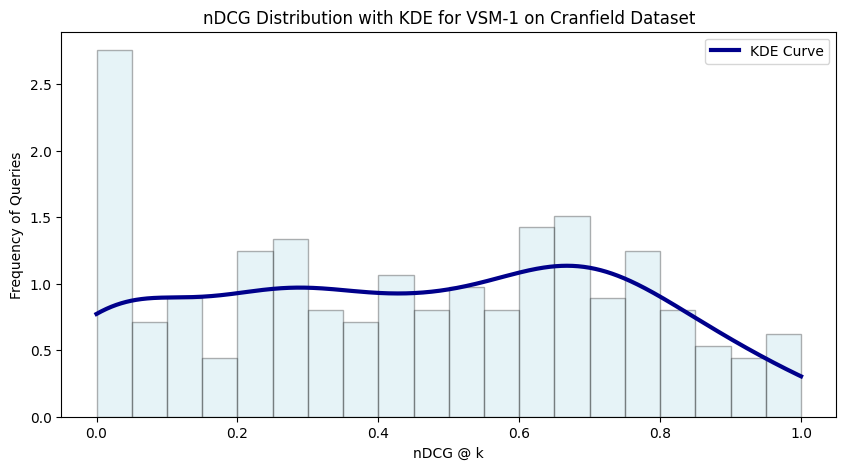

In [ ]:
# from observations import plot
q_precision_vsm1, q_recall_vsm1, q_fscore_vsm1, q_ndcg_vsm1 = plot(qrels, doc_IDs_ordered_vsm1 ,queries, k = 10, model_name = 'VSM-1')

# 2. Modified VSM (VSM-2)

## Processing

In [ ]:
# Loading preprocessed queries
Preprocessed_queries = json.load(open('.\output_VSM-2\stopword_removed_queries.txt', 'r'))
# Loading Preprocessed docs
Preprocessed_docs = json.load(open('.\output_VSM-2\stopword_removed_docs.txt', 'r'))

In [ ]:
# Following are the additional preprocessing used.
def clean_text(text):
    import re
    text = text.lower()
    text = re.sub(r"[^a-z]", " ", text) # This removes anything other than lower case letters(very imp)
    text = re.sub(r"   ", " ", text) # Remove any extra spaces
    return text

def remove_punctuation(text):
    """custom function to remove the punctuation"""
    PUNCT_TO_REMOVE = string.punctuation + '“' + '”'+'’' + '_'
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

In [ ]:
# Apply preprocessing to documents
processed_docs_filtered = []
for doc in Preprocessed_docs:
    filtered_doc = []
    for sentence in doc:
        filtered_sentence = [remove_punctuation(clean_text(word)) for word in sentence]
        filtered_sentence = [word for word in filtered_sentence if word]  # Remove empty strings
        filtered_doc.append(filtered_sentence)
    processed_docs_filtered.append(filtered_doc)

# Apply preprocessing to queries
processed_queries_filtered = []
for query in Preprocessed_queries:
    filtered_query = []
    for sentence in query:
        filtered_sentence = [remove_punctuation(clean_text(word)) for word in sentence]
        filtered_sentence = [word for word in filtered_sentence if word]  # Remove empty strings
        filtered_query.append(filtered_sentence)
    processed_queries_filtered.append(filtered_query)

In [ ]:
# Flatten the list of lists of lists into a single list
flattened_docs = [word for sublist1 in processed_docs_filtered for sublist2 in sublist1 for word in sublist2]
# Count the number of distinct tokens
num_distinct_tokens = len(set(flattened_docs))
print("Number of distinct tokens:", num_distinct_tokens)

Number of distinct tokens: 8801


In [ ]:
# Store filtered processed documents and queries
with open('.\output_VSM-2\\stopword_removed_docs.txt', 'w') as f:
    json.dump(processed_docs_filtered, f)

with open('.\output_VSM-2\\stopword_removed_queries.txt', 'w') as f:
    json.dump(processed_queries_filtered, f)

In [ ]:
# Instantiate the InformationRetrieval class
informationRetriever  = InformationRetrieval()
# Build the index
informationRetriever.buildIndex(processed_docs_filtered, doc_ids)
# Get the ordered document IDs for the queries
doc_IDs_ordered_vsm2 = informationRetriever.rank(processed_queries_filtered)

## Evaluation

Precision, Recall, and F-score @ 1: 0.6711111111111111, 0.1114186321925441, 0.1839666093688092
MAP, nDCG @ 1: 0.1114186321925441, 0.45600000000000046
Precision, Recall, and F-score @ 2: 0.5577777777777778, 0.17937666144409325, 0.25655971852974885
MAP, nDCG @ 2: 0.1733351104025422, 0.43901732489419776
Precision, Recall, and F-score @ 3: 0.48740740740740773, 0.22740537528653254, 0.2904628247542783
MAP, nDCG @ 3: 0.20944733127293302, 0.43321645254954644
Precision, Recall, and F-score @ 4: 0.43444444444444447, 0.26355813742435213, 0.30535073864760937
MAP, nDCG @ 4: 0.23238639320078802, 0.43046640721559204
Precision, Recall, and F-score @ 5: 0.39733333333333376, 0.2964671502602182, 0.3152476173598982
MAP, nDCG @ 5: 0.2518435452625806, 0.43459479916515126
Precision, Recall, and F-score @ 6: 0.3629629629629628, 0.32059984472624603, 0.3158713032448791
MAP, nDCG @ 6: 0.2662722646913, 0.4385941033548172
Precision, Recall, and F-score @ 7: 0.3365079365079371, 0.3459638960706896, 0.316903686677937

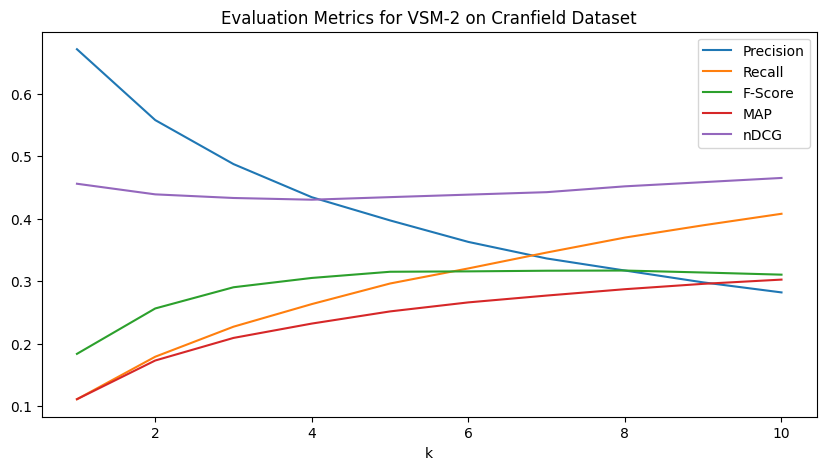

In [ ]:
Evaluation_metrics(doc_IDs_ordered_vsm2, query_ids, qrels,save_results=1, title_name="Evaluation Metrics for VSM-2 on Cranfield Dataset")

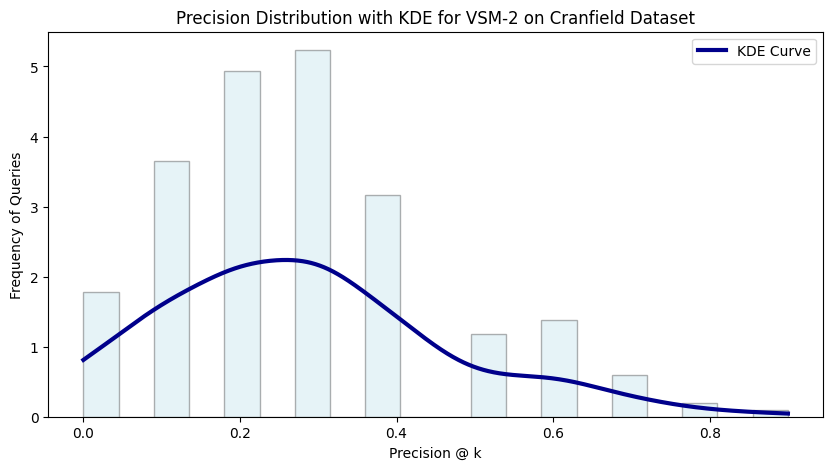

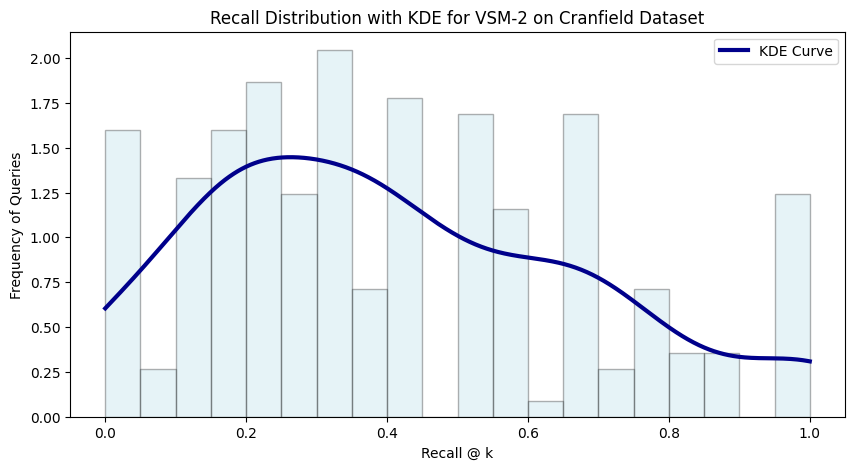

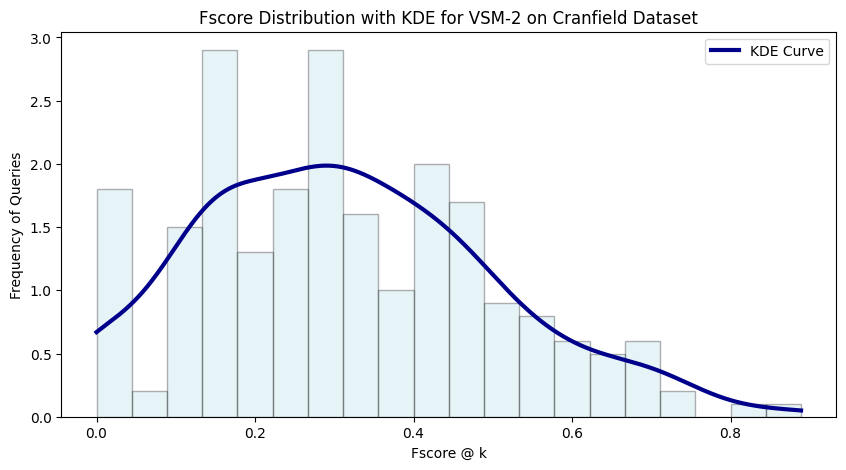

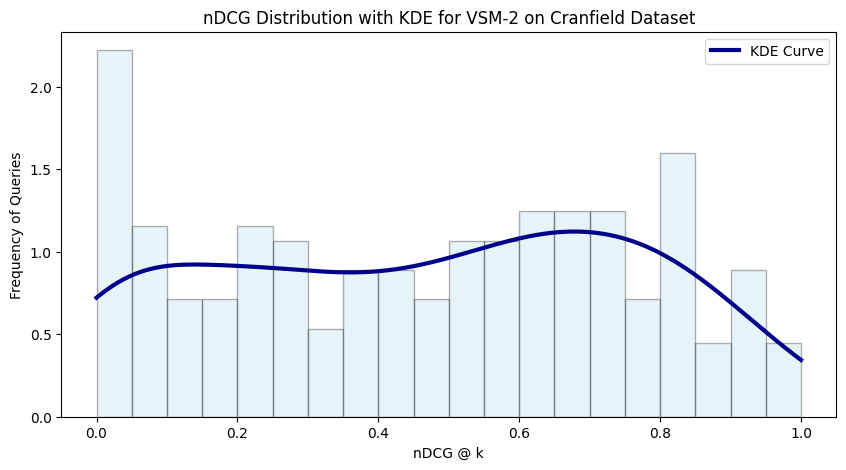

In [ ]:
q_precision_vsm2, q_recall_vsm2, q_fscore_vsm2, q_ndcg_vsm2 = plot(qrels, doc_IDs_ordered_vsm2, queries, k = 10, model_name = 'VSM-2')

## VSM-1 vs. VSM-2

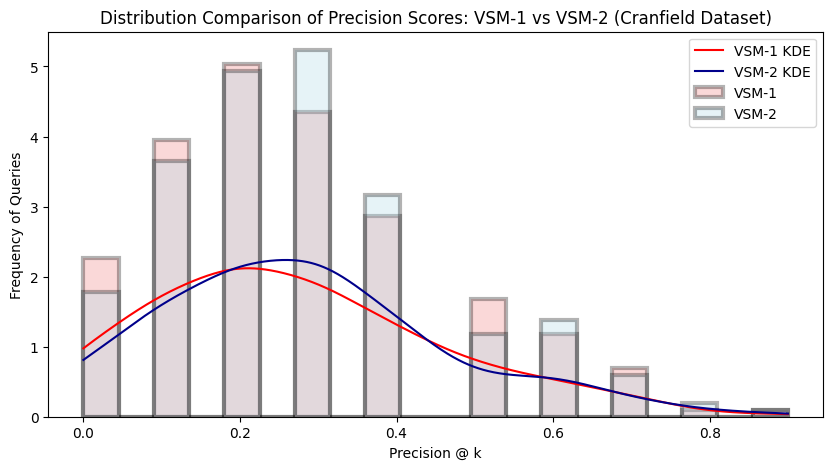

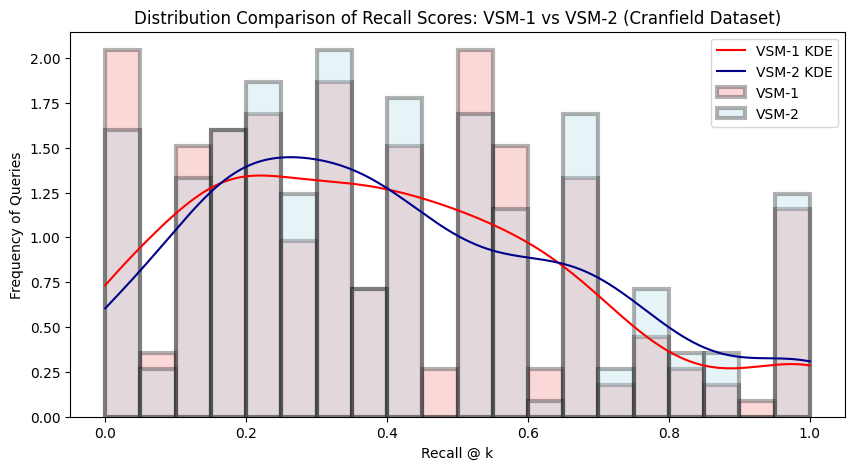

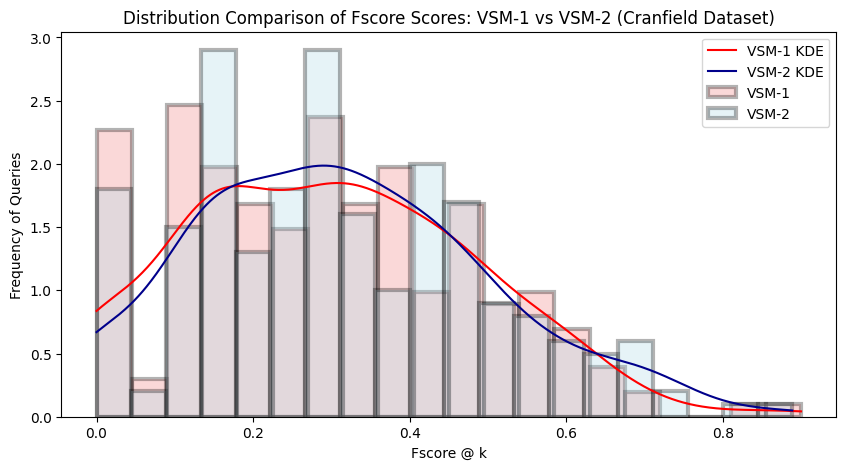

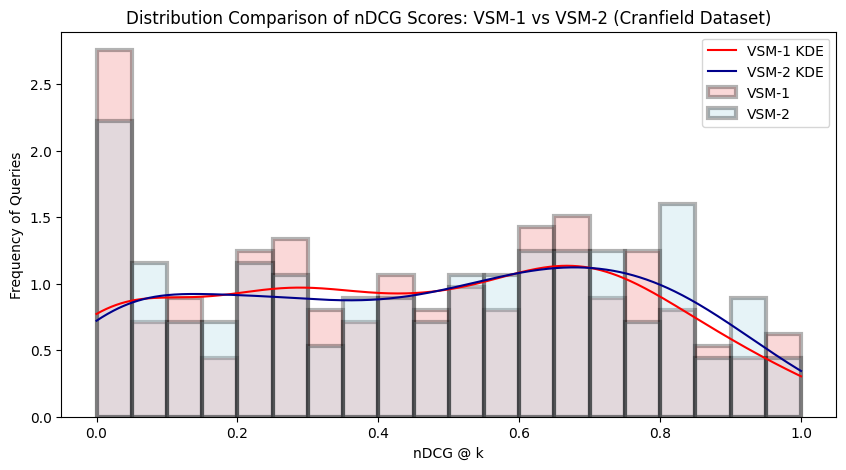

In [ ]:
# from observations import run_comp
plot_comp(q_precision_vsm1, q_precision_vsm2, q_recall_vsm1, q_recall_vsm2, q_fscore_vsm1, q_fscore_vsm2, q_ndcg_vsm1, q_ndcg_vsm2, k = 10, model1_name = 'VSM-1', model2_name = 'VSM-2')

In [ ]:
# VSM-1 Vs VSM-2 (precision)
# from hypoTesting import hypothesis_test
hypothesis_test(q_precision_vsm1, q_precision_vsm2)

t-value: -0.563068945671043
p-value: 0.5736697952350427


In [ ]:
# VSM-1 Vs VSM-2 (recall)
hypothesis_test(q_recall_vsm1, q_recall_vsm2)

t-value: -0.777055931101289
p-value: 0.43753590989214597


In [ ]:
# VSM-1 Vs VSM-2 (f-score)
hypothesis_test(q_fscore_vsm1, q_fscore_vsm2)

t-value: -0.8094429973005224
p-value: 0.41869008542687514


In [ ]:
# VSM-1 Vs VSM-2 (ndcg)
hypothesis_test(q_ndcg_vsm1, q_ndcg_vsm2)

t-value: -0.6147919693314162
p-value: 0.5390042478992794


# LSA

## Processing and Hyperparameter Tuning

In [ ]:
# Following are the additional preprocessing used.
def clean_text(text):
    import re
    text = text.lower()
    text = re.sub(r"[^a-z]", " ", text) # This removes anything other than lower case letters(very imp)
    text = re.sub(r"   ", " ", text) # Remove any extra spaces
    return text

def remove_punctuation(text):
    """custom function to remove the punctuation"""
    PUNCT_TO_REMOVE = string.punctuation + '“' + '”'+'’' + '_'
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

def lemmatize_words(text):
    lemmatizer = WordNetLemmatizer()
    wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

In [ ]:
# Apply the above preprocessing on to queries and docs
query_df = pd.DataFrame(queries,columns = ['query'])
docs_df = pd.DataFrame(docs_json).drop(['author','bibliography','id','title'],axis=1)

docs_df['preprocessed'] = docs_df['body'].str.lower()
query_df['preprocessed'] = query_df['query'].str.lower()

docs_df['preprocessed'] = docs_df['preprocessed'].apply(clean_text)
query_df['preprocessed'] = query_df['preprocessed'].apply(clean_text)

docs_df['preprocessed'] = docs_df['preprocessed'].apply(lambda text: remove_punctuation(text))
query_df['preprocessed'] = query_df['preprocessed'].apply(lambda text: remove_punctuation(text))

docs_df['preprocessed'] = docs_df['preprocessed'].apply(lambda text: remove_stopwords(text))
query_df['preprocessed'] = query_df['preprocessed'].apply(lambda text: remove_stopwords(text))

docs_df['preprocessed'] = docs_df['preprocessed'].apply(lambda text: lemmatize_words(text))
query_df['preprocessed'] = query_df['preprocessed'].apply(lambda text: lemmatize_words(text))

docs_df.head()

,body,preprocessed
0,experimental investigation of the aerodynamics...,experimental investigation aerodynamics wing s...
1,simple shear flow past a flat plate in an inco...,simple shear flow past flat plate incompressib...
2,the boundary layer in simple shear flow past a...,boundary layer simple shear flow past flat pla...
3,approximate solutions of the incompressible la...,approximate solution incompressible laminar bo...
4,one-dimensional transient heat conduction into...,one dimensional transient heat conduction doub...


In [ ]:
# combining the documents and queries.
corpus = docs_df['preprocessed'].tolist() + query_df['preprocessed'].tolist()
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names_out()
columns = ['doc_' + str(i) for i in range(1,X.shape[0]+1)]

tfidf_df = pd.DataFrame(X.T.todense(), index=feature_names, columns=columns)
tf_idf_docs_lsa = tfidf_df[columns[:len(docs_df)]].values
vec_rep_queries_lsa = tfidf_df[columns[len(docs_df):]].values
tfidf_df.head()

,doc_1,doc_2,doc_3,doc_4,doc_5,doc_6,doc_7,doc_8,doc_9,doc_10,...,doc_1616,doc_1617,doc_1618,doc_1619,doc_1620,doc_1621,doc_1622,doc_1623,doc_1624,doc_1625
ab,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abbreviated,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ability,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ablate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ablation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



LSA with 100 in progress


LSA with 200 in progress


LSA with 300 in progress


LSA with 400 in progress


LSA with 500 in progress


LSA with 600 in progress


LSA with 700 in progress


LSA with 800 in progress


LSA with 900 in progress


LSA with 1000 in progress

Highest MAP: 0.3324114507043216 achieved with 500 components


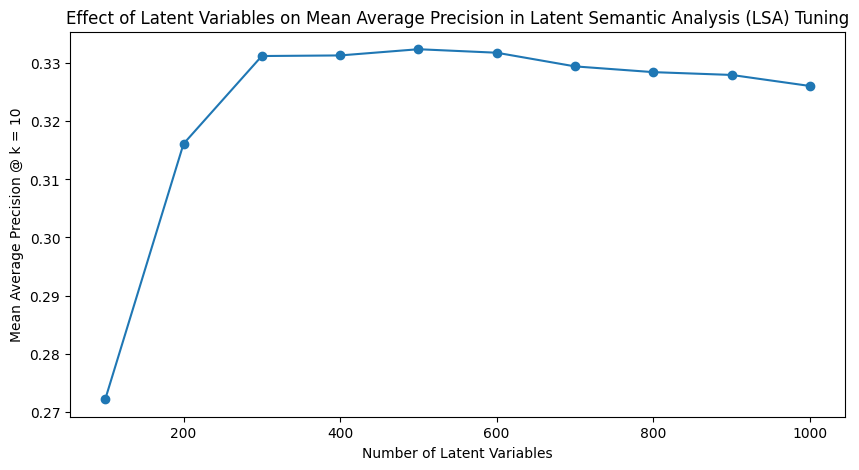

In [ ]:
from sklearn.decomposition import TruncatedSVD
components_used = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
evaluator = Evaluation()
MAP = []
max_MAP = 0
best_n_comp = None

for n_comp in components_used:
    # using Singular value decomposition
    svd = TruncatedSVD(n_components=n_comp)
    svd.fit(tf_idf_docs_lsa.T)
    # transformed documents
    tr_docs_lsa = svd.transform(tf_idf_docs_lsa.T).T
    # transformed queries
    qr_tr_lsa = svd.transform(vec_rep_queries_lsa.T).T
    # cosine similarity
    cosine_sim_lsa = np.matmul(tr_docs_lsa.T, qr_tr_lsa)
    # documents ranking for queries using lsa
    doc_IDs_ordered_lsa = (np.argsort(cosine_sim_lsa, axis=0) + 1)[::-1].T.tolist()
    print("\nLSA with " + str(n_comp) + " in progress\n")
    # Calculate MAP
    map_value = evaluator.meanAveragePrecision(doc_IDs_ordered_lsa, query_ids, qrels, k=10)
    # Storing all the MAP values for each n_comp
    MAP.append(map_value)
    # Check if this MAP is the highest
    if map_value > max_MAP:
        max_MAP = map_value
        best_n_comp = n_comp

print(f"Highest MAP: {max_MAP} achieved with {best_n_comp} components")

plt.figure(figsize=(10, 5))
plt.plot(components_used, MAP)
plt.scatter(components_used, MAP)
plt.title('Effect of Latent Variables on Mean Average Precision in Latent Semantic Analysis (LSA) Tuning')
plt.xlabel('Number of Latent Variables')
plt.ylabel('Mean Average Precision @ k = 10')
plt.show()

## Evaluation

Precision, Recall, and F-score @ 1: 0.7111111111111111, 0.11957588007786213, 0.1959319691628584
MAP, nDCG @ 1: 0.11957588007786213, 0.49955555555555603
Precision, Recall, and F-score @ 2: 0.5844444444444444, 0.1921869345777712, 0.27167138695461024
MAP, nDCG @ 2: 0.18756251578668573, 0.4709277954900507
Precision, Recall, and F-score @ 3: 0.5170370370370371, 0.24733454935750243, 0.3110472737112764
MAP, nDCG @ 3: 0.23252923242383303, 0.46525402195616744
Precision, Recall, and F-score @ 4: 0.46555555555555556, 0.2921030074914102, 0.3321225172288105
MAP, nDCG @ 4: 0.26398532173244094, 0.4690919390350368
Precision, Recall, and F-score @ 5: 0.41688888888888925, 0.3189193547732071, 0.33326727809912626
MAP, nDCG @ 5: 0.27930317170657226, 0.4709016167530327
Precision, Recall, and F-score @ 6: 0.3829629629629629, 0.3455152120874552, 0.3348396881976887
MAP, nDCG @ 6: 0.29461259692021197, 0.47673656877449255
Precision, Recall, and F-score @ 7: 0.36126984126984174, 0.3754934617741673, 0.339807955717

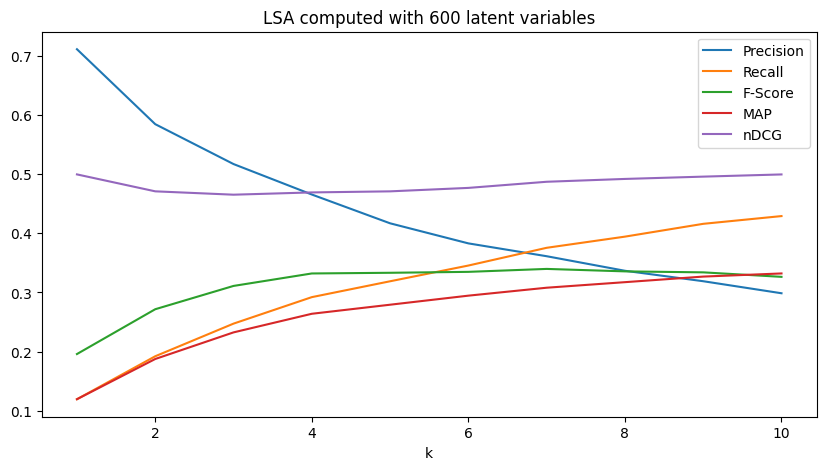

In [ ]:
n_comp = 600
svd = TruncatedSVD(n_components=n_comp)
svd.fit(tf_idf_docs_lsa.T)
tr_docs_lsa = svd.transform(tf_idf_docs_lsa.T).T
qr_tr_lsa = svd.transform(vec_rep_queries_lsa.T).T
cosine_sim_lsa = np.matmul(tr_docs_lsa.T, qr_tr_lsa)
doc_IDs_ordered_lsa = (np.argsort(cosine_sim_lsa,axis=0)+1)[::-1].T.tolist()
title = "LSA computed with "+ str(n_comp) + " latent variables"
Evaluation_metrics(doc_IDs_ordered_lsa, query_ids, qrels,save_results=1, title_name=title)

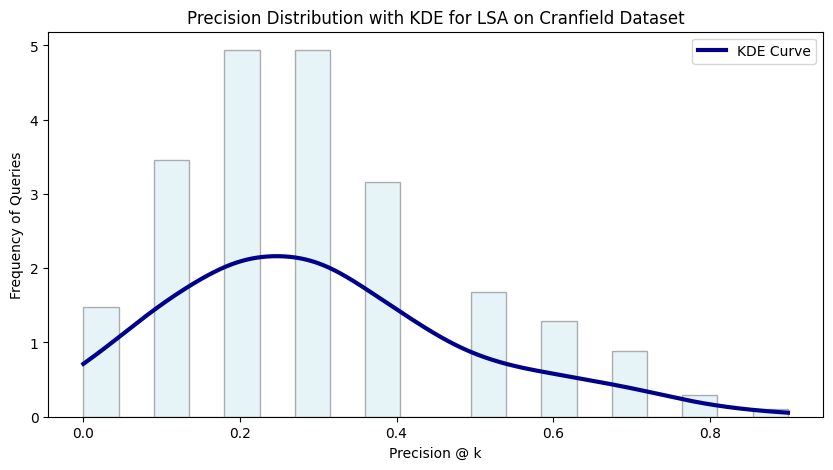

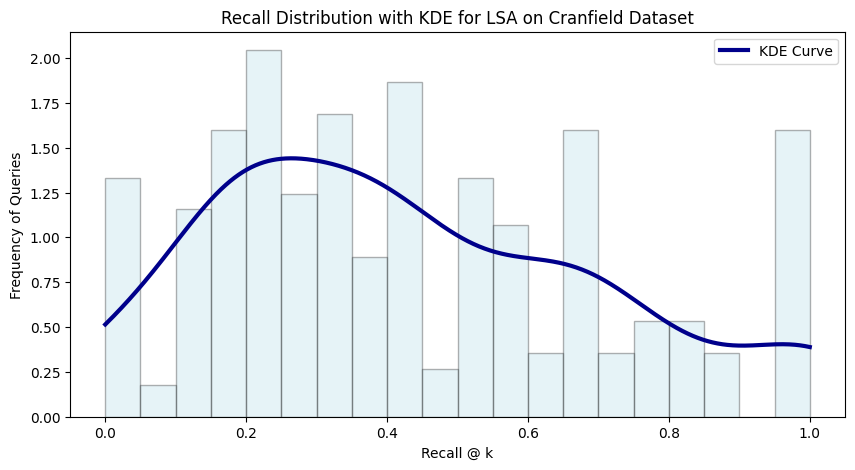

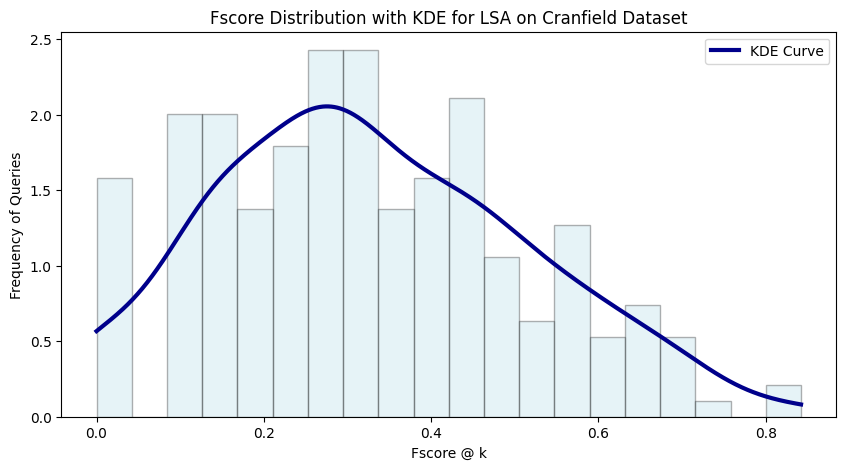

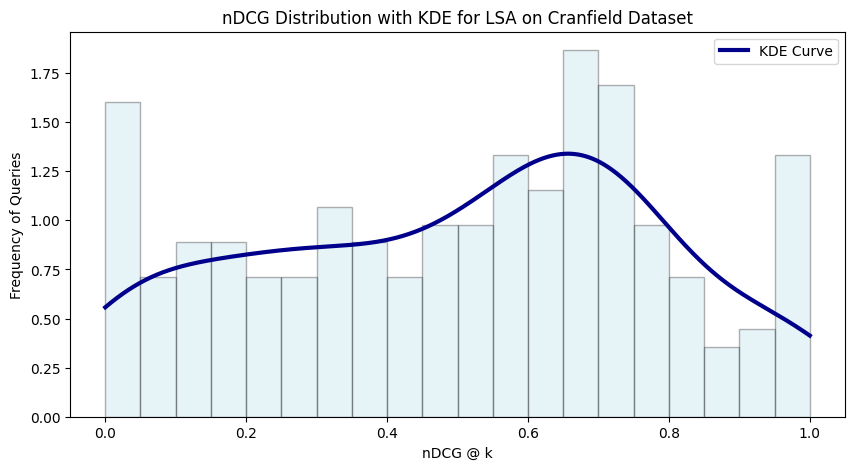

In [ ]:
q_precision_lsa, q_recall_lsa, q_fscore_lsa, q_ndcg_lsa = plot(qrels, doc_IDs_ordered_lsa, queries, k = 10, model_name = 'LSA')

## VSM-2 vs. LSA

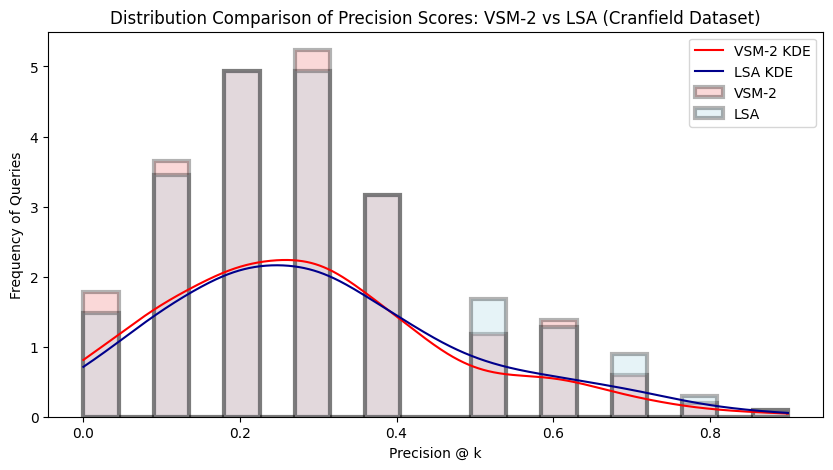

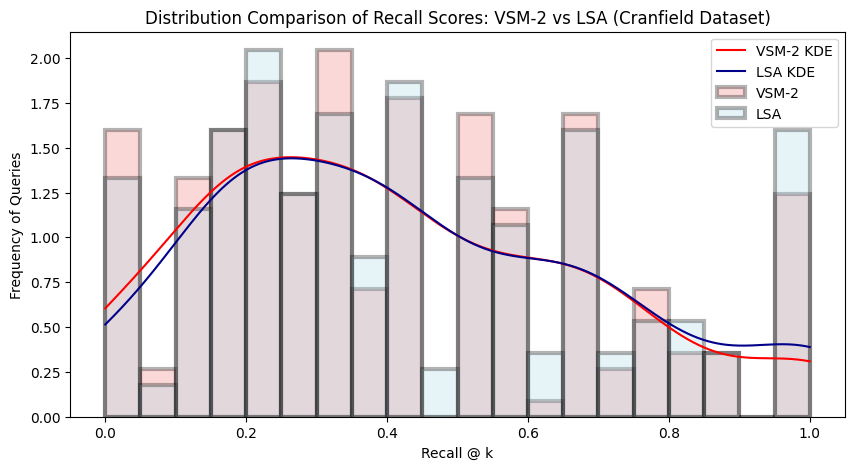

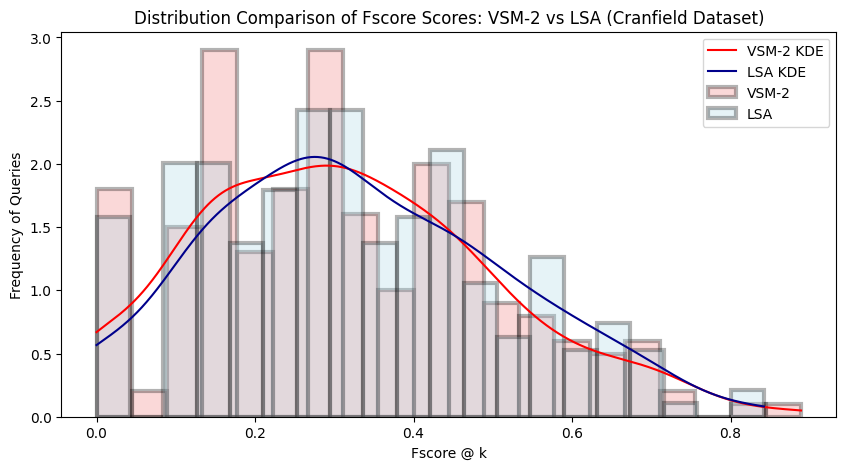

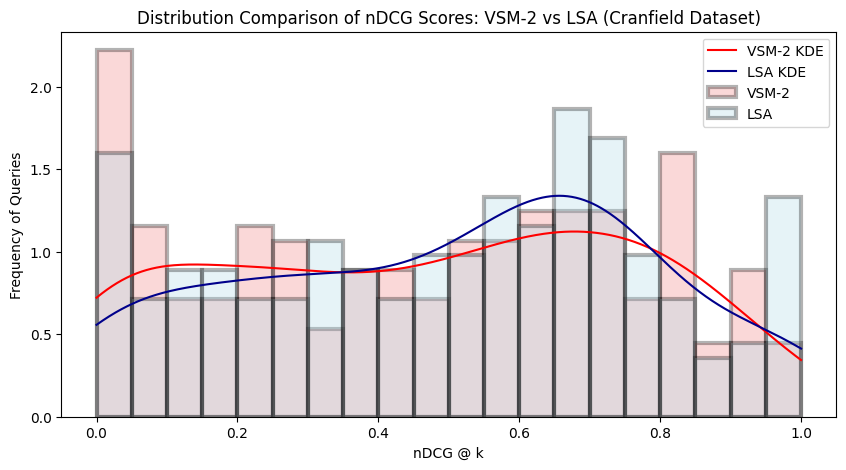

In [ ]:
plot_comp(q_precision_vsm2, q_precision_lsa, q_recall_vsm2, q_recall_lsa, q_fscore_vsm2, q_fscore_lsa, q_ndcg_vsm2, q_ndcg_lsa, k = 10, model1_name = 'VSM-2', model2_name = 'LSA')

In [ ]:
# Hypothesis Testing VSM-2 Vs LSA
print('Precision')
hypothesis_test(q_precision_vsm2, q_precision_lsa)

print('Recall')
hypothesis_test(q_recall_vsm2, q_recall_lsa)

print('FScore')
hypothesis_test(q_fscore_vsm2, q_fscore_lsa)

print('nDCG')
hypothesis_test(q_ndcg_vsm2, q_ndcg_lsa)

Precision
t-value: -0.9414074754180342
p-value: 0.34700409917504604
Recall
t-value: -0.8204012779529363
p-value: 0.4124239016888722
FScore
t-value: -0.8999100788103918
p-value: 0.36865156813118405
nDCG
t-value: -1.2482768331620675
p-value: 0.2125824288875447


## Observations

In [ ]:
df = pd.DataFrame(qrels)
print("Query id : 109 ")
print("query: ", query_df.loc[108,'query'])
print("Retrieval by LSA : ",doc_IDs_ordered_lsa[108][:10])
print("Retrieval by VSM-2 :", doc_IDs_ordered_vsm2[108][:10])
print("Document 31: ", docs_df.loc[30, 'body'])
print("Document 627: ", docs_df.loc[626, 'body'])
print("Document 766: ", docs_df.loc[765, 'body'])

Query id : 109 
query:  panels subjected to aerodynamic heating .
Retrieval by LSA :  [859, 1008, 658, 857, 856, 391, 766, 627, 858, 864]
Retrrieval by VSM-2 : [31, 51, 859, 627, 864, 1008, 142, 285, 982, 856]
Document 31:  thermal buckling of supersonic wing panels .   the temperature and thermal stress distributions are analyzed in multicellular supersonic wing structures .  a buckling criterion is established for the panels of cover plates subjected to thermal stresses .
Document 627:  flutter analysis of circular panels .   the flutter problem of flat circular panels with edges elastically restrained against rotation has been formulated in terms of small-deflection plate theory .  the panel is subjected to uniform all-round tension or compression in its middle plane, in addition to the supersonic compressible flow passing over its upper surface with still air below .  linear piston theory is employed to predict the aerodynamic load on the vibrating panel .   the problem is investig

# K means Clustering with LSA

## Processing and Hyperparameter Tuning

In [ ]:
tf_idf_docs_lsa.T.shape

(1400, 5597)

For n_clusters = 2, silhouette score is 0.011311338707102539)
For n_clusters = 3, silhouette score is 0.013145796137173612)
For n_clusters = 4, silhouette score is 0.011353935449882044)
For n_clusters = 5, silhouette score is 0.01521780287579513)
For n_clusters = 6, silhouette score is 0.014512685505746768)
For n_clusters = 7, silhouette score is 0.015623128951031486)
For n_clusters = 8, silhouette score is 0.011993872703737255)
For n_clusters = 9, silhouette score is 0.016591655860868828)
For n_clusters = 10, silhouette score is 0.018932011490435805)
For n_clusters = 11, silhouette score is 0.017100962113668027)


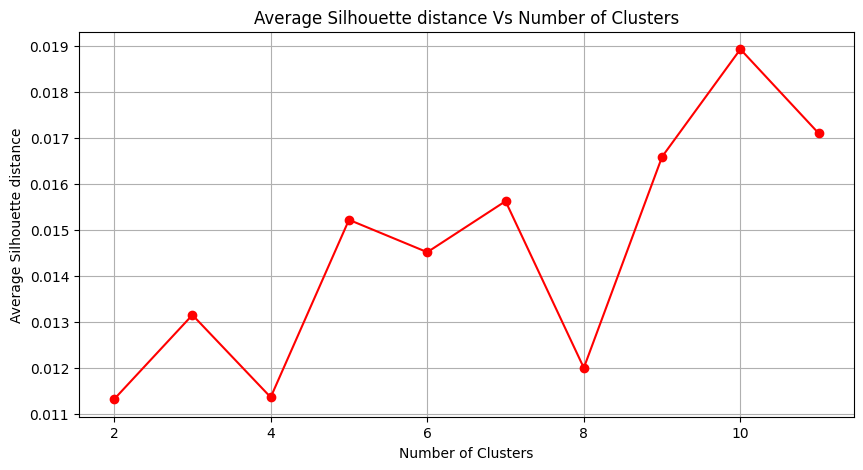

In [ ]:
# TF-IDF representation of documents
df_cluster = tf_idf_docs_lsa.T

# List to store silhouette scores
sil_scores = []

# Tuning number of clusters using grid search, from 2 to 20
for n_clusters in range(2, 12):
    # Applying K-means
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(df_cluster)

    # Finding cluster centers
    centers = clusterer.cluster_centers_

    # Calculating silhouette score
    score = silhouette_score(df_cluster, preds)
    sil_scores.append(score)

    # Printing silhouette score for each cluster size
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

# Plotting silhouette scores against number of clusters
plt.figure(figsize=(10, 5))
plt.plot(list(range(2, 12)), sil_scores, marker='o', color='r')
plt.title("Average Silhouette distance Vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Average Silhouette distance")
plt.grid(True)
plt.show()

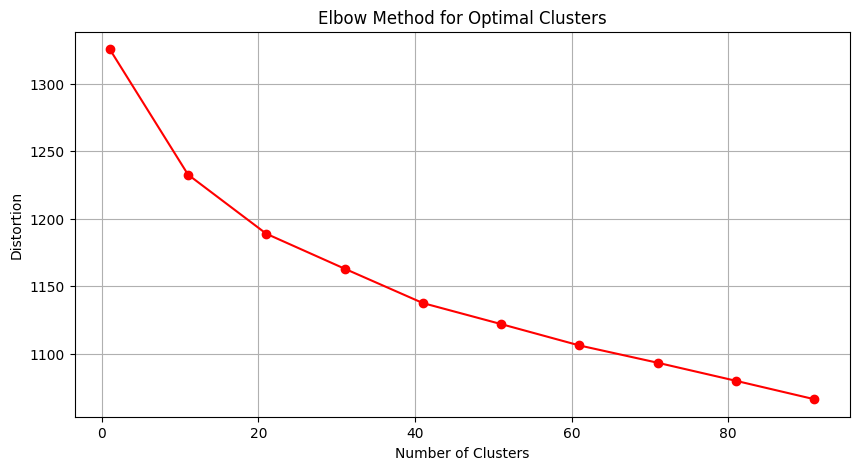

In [ ]:
# List to store distortions
distortions = []
# Calculate distortion for a range of number of clusters
for i in range(1, 100, 10):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(tf_idf_docs_lsa.T)
    distortions.append(km.inertia_)
# Plotting the Elbow plot to find the optimal number of clusters
plt.figure(figsize=(10, 5))
plt.plot(list(range(1, 100, 10)), distortions, marker='o', color='r')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.grid(True)
plt.show()

In [ ]:
# Combine the preprocessed documents and queries
corpus = docs_df['preprocessed'].tolist() + query_df['preprocessed'].tolist()
# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()
# Fit and transform the corpus
X = vectorizer.fit_transform(corpus)
# Get feature names
feature_names = vectorizer.get_feature_names_out()
# Generate column names for the dataframe
columns = ['doc_' + str(i) for i in range(1, X.shape[0] + 1)]
# Create a DataFrame from TF-IDF matrix
tfidf_df = pd.DataFrame(X.T.todense(), index=feature_names, columns=columns)
# Extract TF-IDF representations of documents and queries
tf_idf_docs_km = tfidf_df[columns[:len(docs_df)]].values # final representations of documents
vec_rep_queries_km = tfidf_df[columns[len(docs_df):]].values # final representations of queries

In [ ]:
# Initialize KMeans with the best value of k
k = 9
km = KMeans(n_clusters=k, random_state=0)
# Fit KMeans clustering on TF-IDF representations of documents
km.fit(tf_idf_docs_km.T)
# Get the cluster centers shape
cluster_centers_shape = km.cluster_centers_.shape

In [ ]:
print(np.shape(vec_rep_queries_km))

(5597, 225)


In [ ]:
print(cluster_centers_shape)

(9, 5597)


In [ ]:
cluster_doc_ids = {}
# assigning documents to various clusters
for i in range(1400):
    try :
        cluster_doc_ids[km.labels_[i]] += [i]
    except :
        cluster_doc_ids[km.labels_[i]] = [i]

In [ ]:
print(cluster_doc_ids)

{5: [0, 13, 51, 59, 146, 199, 202, 203, 204, 221, 224, 225, 226, 228, 229, 245, 246, 249, 250, 278, 283, 286, 287, 288, 310, 361, 419, 431, 432, 433, 441, 452, 463, 464, 512, 519, 544, 560, 598, 599, 600, 611, 631, 632, 636, 637, 642, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 685, 697, 698, 699, 700, 702, 703, 707, 708, 711, 746, 747, 748, 751, 754, 778, 779, 780, 781, 782, 790, 791, 792, 793, 795, 796, 802, 810, 859, 876, 878, 894, 899, 900, 901, 915, 916, 917, 918, 919, 920, 922, 923, 1061, 1063, 1073, 1074, 1088, 1089, 1090, 1091, 1093, 1094, 1114, 1143, 1161, 1162, 1163, 1169, 1185, 1187, 1196, 1238, 1242, 1245, 1265, 1271, 1276, 1279, 1288, 1289, 1319, 1330, 1331, 1332, 1333, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1379], 8: [1, 2, 3, 6, 7, 8, 15, 16, 20, 21, 22, 23, 36, 39, 42, 44, 49, 52, 53, 54, 58, 61, 70, 71, 73, 75, 78, 79, 88, 93, 95, 104, 106, 110, 114, 124, 125, 132, 133, 134, 139, 141, 144, 147, 149, 154, 164, 169, 179, 181, 186, 191, 206, 241, 253, 254, 2

In [ ]:
import time
# normal method of retrieval
tic = time.time()
# for finding the average retrieval time for a query.
# iterating over queries
for j in range(200):
    cosine_sim_clust = []
    # iterating over all documents
    for i in range(1400):
        # cosine similarity
        cosine_sim_clust.append(np.matmul(tf_idf_docs_km[:,i].T, vec_rep_queries_km[:,j]))
    cosine_sim_clust = np.array(cosine_sim_clust)
    doc_IDs_ordered_clust = (np.argsort(cosine_sim_clust,axis=0)+1)[::-1].T.tolist()
toc = time.time()
print("without clustering, Average Retrieval time : "+str((toc-tic)/200))

# clustering method
tic = time.time()
doc_IDs_ordered_kmeans = []
# iterating over queries
for j in range(200):
    cluster = np.argmax(np.matmul(vec_rep_queries_km[:,j].T, km.cluster_centers_.T))
    cluster_docs = tf_idf_docs_km[:, cluster_doc_ids[cluster]]
    cosine_sim = np.matmul(cluster_docs.T,vec_rep_queries_km[:,0])
    doc_IDs_ordered_clust = (np.argsort(cosine_sim,axis=0))[::-1].T.tolist()
    doc_IDs_ordered_kmeans.append(doc_IDs_ordered_clust)
    #doc_IDs_ordered = np.array(cluster_doc_ids[cluster])[doc_IDs_ordered_clust]+1
toc = time.time()
print("clustering method, Retrieval time : "+str((toc-tic)/200))


without clustering, Average Retrieval time : 0.006029900312423706
clustering method, Retrieval time : 0.0023406147956848145


In [ ]:
doc_IDs_ordered_kmeans = []
# iterating over queries
for j in range(225):
    cluster = np.argmax(np.matmul(vec_rep_queries_km[:,j].T, km.cluster_centers_.T))
    cluster_docs = tf_idf_docs_km[:, cluster_doc_ids[cluster]]
    cosine_sim = np.matmul(cluster_docs.T,vec_rep_queries_km[:,0])
    doc_IDs_ordered_clust = (np.argsort(cosine_sim,axis=0))[::-1].T.tolist()
    doc_IDs_ordered_kmeans.append(doc_IDs_ordered_clust)
    doc_IDs_ordered = np.array(cluster_doc_ids[cluster])[doc_IDs_ordered_clust]+1

In [ ]:
len(doc_IDs_ordered_kmeans)

225

In [ ]:
# we store the retrieval time taken for each query and store them as a list
without_clust = []
# iterating over 200 queries
for j in range(200):
    tic = time.time()
    cosine_sim = []
    for i in range(1400):
        cosine_sim.append(np.matmul(tf_idf_docs_km[:,i].T, vec_rep_queries_km[:,j]))
    cosine_sim = np.array(cosine_sim)
    doc_IDs_ordered = (np.argsort(cosine_sim,axis=0)+1)[::-1].T.tolist()
    toc = time.time()
    without_clust.append((toc-tic))

with_clust = []
# clustering method
for j in range(200):
    tic = time.time()
    cluster = np.argmax(np.matmul(vec_rep_queries_km[:,j].T, km.cluster_centers_.T))
    cluster_docs = tf_idf_docs_km[:, cluster_doc_ids[cluster]]
    cosine_sim = np.matmul(cluster_docs.T,vec_rep_queries_km[:,0])
    doc_IDs_ordered_clus = (np.argsort(cosine_sim,axis=0))[::-1].T.tolist()
    doc_IDs_ordered = np.array(cluster_doc_ids[cluster])[doc_IDs_ordered_clus]+1
    toc = time.time()
    with_clust.append((toc-tic))

In [ ]:
import plotly.graph_objs as go

# Convert range(200) to a list
x_values = list(range(200))

# Create traces for the two lines
trace1 = go.Scatter(x=x_values, y=without_clust, mode='lines', name='Without Clustering')
trace2 = go.Scatter(x=x_values, y=with_clust, mode='lines', name='With Clustering')

# Create layout
layout = go.Layout(title='Clustering with Kmeans',
                   xaxis=dict(title='Iterations'),
                   yaxis=dict(title='Time'),
                   title_x=0.5,  # Title centered horizontally
                   title_xanchor='center')  # Title centered horizontally

# Create figure object
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show the plot
fig.show()



In [ ]:
# hypothesis testing
hypothesis_test(without_clust, with_clust)

t-value: 41.171364240829185
p-value: 2.153049170712755e-145


In [ ]:
from gensim.models import FastText
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

In [ ]:
corpus = docs_df['preprocessed'].tolist() + query_df['preprocessed'].tolist()
All_sentences = [sent.split(" ") for sent in corpus]

In [ ]:
# Train FastText model on corpus
model = FastText(min_count=1, window=3, vector_size=500, sample=6e-5)
model.build_vocab(All_sentences)
model.train(All_sentences, total_examples=model.corpus_count, epochs=50)

(2607272, 6560650)

In [ ]:
res = model.wv.most_similar("aircraft", topn=10)
similar_words = [word for word, _ in res]

In [ ]:
print(similar_words)

['craft', 'hovercraft', 'erode', 'vtol', 'damage', 'spacecraft', 'operating', 'design', 'modest', 'role']


In [ ]:
# Define query expansion function using FastText model
def query_expansion(query, ft_model, v=1):
    expanded_query = []
    for sent in query:
        for word in sent:
            try:
                expanded_query.extend(np.array(ft_model.wv.most_similar(positive=[word], topn=v))[:,0])
            except KeyError:
                pass
    return " ".join(expanded_query)

In [ ]:
# Apply query expansion to preprocessed queries
query_df['expanded_query'] = query_df["preprocessed"].apply(lambda x: query_expansion([x.split(" ")], model))
query_df['expanded_query'] += query_df['preprocessed']

In [ ]:
# Vectorize documents and expanded queries using TF-IDF
vectorizer = TfidfVectorizer()
corpus_qe = docs_df['preprocessed'].tolist() + query_df['expanded_query'].tolist()
X = vectorizer.fit_transform(corpus_qe)

,doc_1,doc_2,doc_3,doc_4,doc_5,doc_6,doc_7,doc_8,doc_9,doc_10,...,doc_1616,doc_1617,doc_1618,doc_1619,doc_1620,doc_1621,doc_1622,doc_1623,doc_1624,doc_1625
ab,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abbreviated,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ability,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ablate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ablation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Compute cosine similarity between documents and expanded queries
num_docs = len(docs_df)  # Assuming docs_df contains information about the documents
cosine_sim_qe = np.matmul(tfidf_df.iloc[:, :num_docs].T, tfidf_df.iloc[:, num_docs:].values)
doc_IDs_ordered_qe = (np.argsort(cosine_sim_qe, axis=0) + 1)[::-1].T.tolist()

## Evaluation

Precision, Recall, and F-score @ 1: 0.6044444444444445, 0.10424776856089614, 0.17075492127476816
MAP, nDCG @ 1: 0.10424776856089614, 0.4355555555555558
Precision, Recall, and F-score @ 2: 0.5288888888888889, 0.17184524809957358, 0.24428066506528107
MAP, nDCG @ 2: 0.1608641470044374, 0.4345442474748693
Precision, Recall, and F-score @ 3: 0.4607407407407408, 0.2198283422147841, 0.2765243787318597
MAP, nDCG @ 3: 0.1969937337458791, 0.4250240266278191
Precision, Recall, and F-score @ 4: 0.4033333333333333, 0.2514989543187296, 0.2869327546456526
MAP, nDCG @ 4: 0.21805547046594914, 0.42356167878384643
Precision, Recall, and F-score @ 5: 0.3706666666666672, 0.28246143809493895, 0.29670848844615616
MAP, nDCG @ 5: 0.23575459305722857, 0.4270225070000272
Precision, Recall, and F-score @ 6: 0.34, 0.30573855785245074, 0.2974474164390208
MAP, nDCG @ 6: 0.24757387078990498, 0.4304929789607605
Precision, Recall, and F-score @ 7: 0.31365079365079396, 0.3279597872403468, 0.29648163092738933
MAP, nDCG @

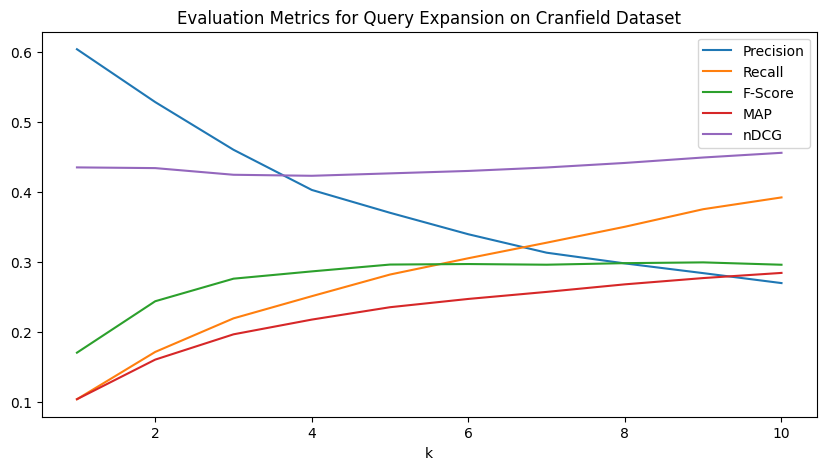

In [ ]:
Evaluation_metrics(doc_IDs_ordered_qe, query_ids, qrels,save_results=1, title_name="Evaluation Metrics for Query Expansion on Cranfield Dataset")

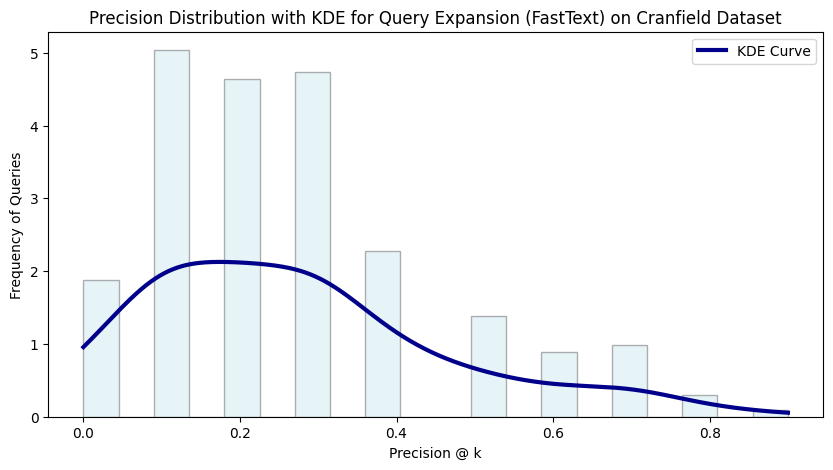

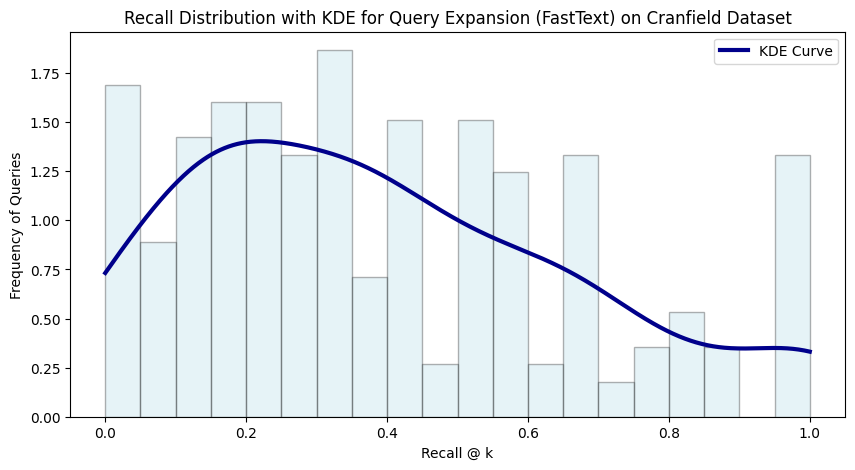

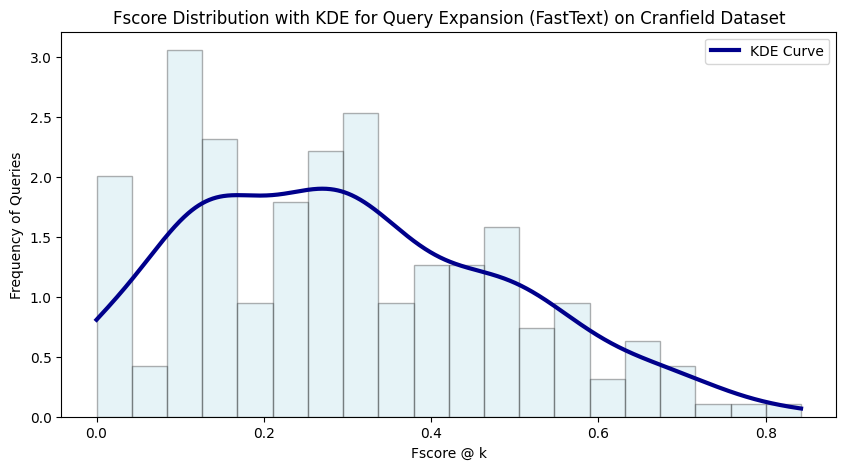

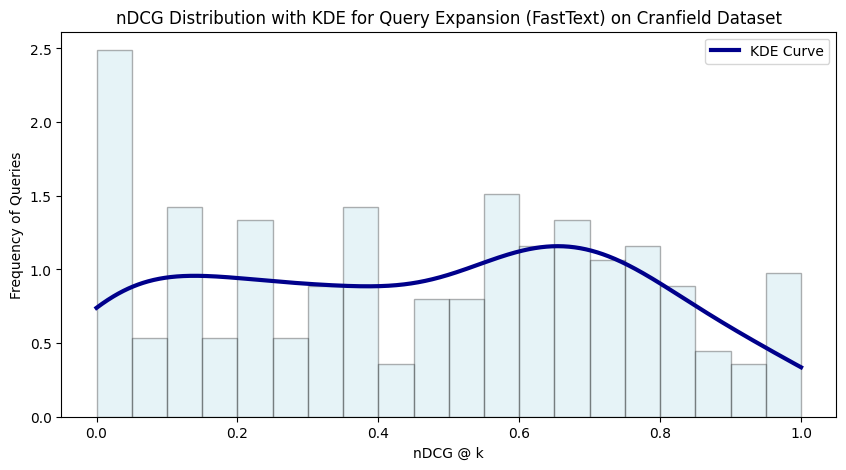

In [ ]:
q_precision_qe, q_recall_qe, q_fscore_qe, q_ndcg_qe = plot(qrels, doc_IDs_ordered_qe,
                                                                 queries, k = 10, model_name = 'Query Expansion (FastText)')

## VSM-2 vs. Query Expansion

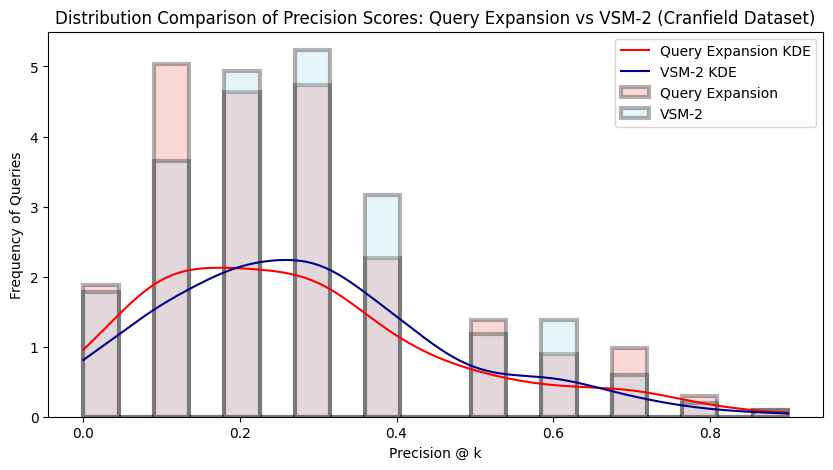

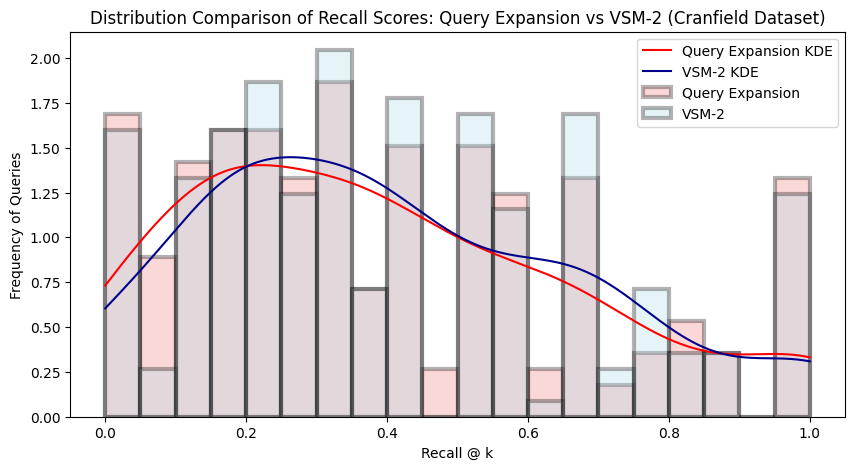

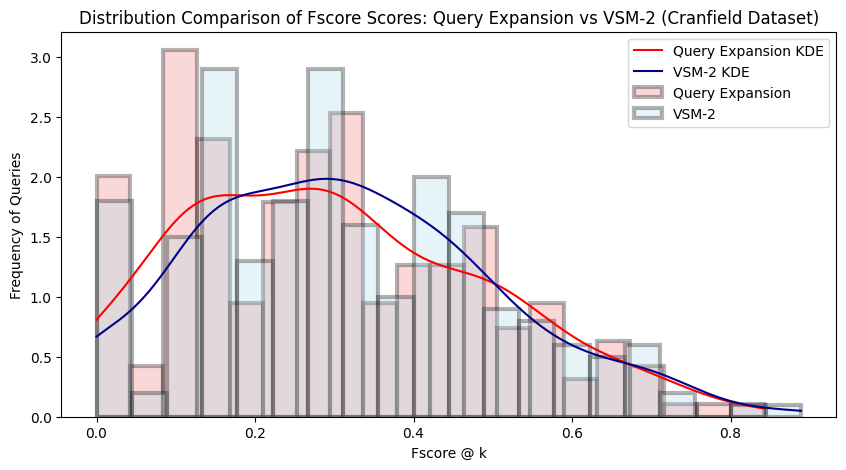

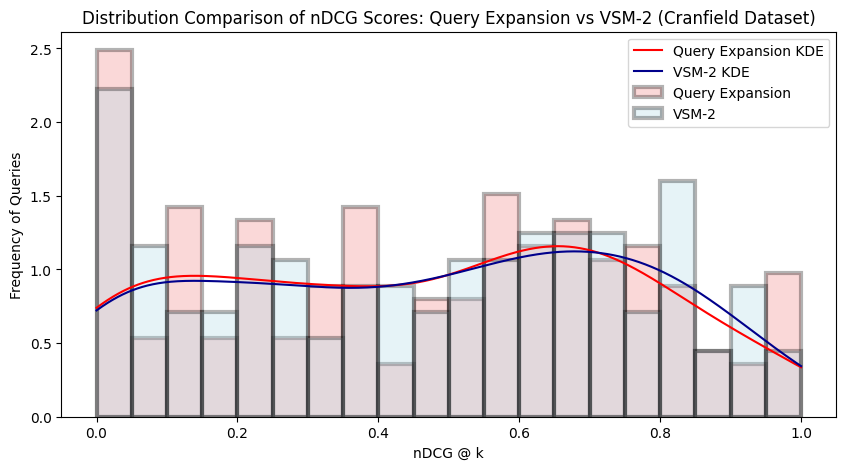

In [ ]:
plot_comp(q_precision_qe, q_precision_vsm2, q_recall_qe, q_recall_vsm2, q_fscore_qe, q_fscore_vsm2, q_ndcg_qe, q_ndcg_vsm2, k = 10, model1_name = 'Query Expansion', model2_name = 'VSM-2')

In [ ]:
print("Query id : 109 ")
print("Expanded Query : ", query_df['expanded_query'][108])
print("Preprocessed Query : ", query_df['preprocessed'][108])
print("query: ", query_df.loc[108,'query'])
print("Words Added : ",query_df['expanded_query'][108].split(' ')[:10])
print("Retrieved : ",doc_IDs_ordered_qe[108][:10])
# print("Relevant : ", list(map(int, df[df['query_num'] == str(84)]['id'].tolist())))
print("Document 500: ", docs_df.loc[499, 'body'])

Query id : 109 
Expanded Query :  sting web aerodynamics freedompanel subject aerodynamic heating
Preprocessed Query :  panel subject aerodynamic heating
query:  panels subjected to aerodynamic heating .
Words Added :  ['sting', 'web', 'aerodynamics', 'freedompanel', 'subject', 'aerodynamic', 'heating']
Retrieved :  [419, 860, 431, 51, 188, 95, 1387, 179, 1348, 5]
Document 500:  joule heating in magnetohydrodynamic free-convection flows .   the steady, fully developed, laminar, free-convection flow of an electrically conducting fluid between two fully submerged open-ended, constant-temperature vertical plates located in a constant, uniformly distributed, transverse magnetic field has been analyzed with the joule heating term retained in the energy equation . analytic results are obtained .  such analytic results are useful in estimating the actual magnitude of the influence of joule heating as well as a qualitative description of the manner in which it alters the temperature and flow f